In [1]:
# Data Management/Investigation
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import missingno as miss
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import country_converter as coco

# For pre-processing data
from sklearn import preprocessing as pp
from sklearn.compose import ColumnTransformer

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods
from sklearn.linear_model import LinearRegression as LM
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTree
from sklearn.ensemble import BaggingRegressor as Bag
from sklearn.ensemble import RandomForestRegressor as RF

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Language Fractionalization Project 
## By Sahithi N Adari

### Definition

##### Ethnolinguistic Fractionalization (ELF): Refers to the probability that two randomly selected individuals from a population belonged to different groups
* High ELF means  that the ethnicites and languages in a country are fairly heterogeneous (think India)

* Low ELF means that the ethnicites and languages in a country are fairly homogenous (think Japan) 

### Background

##### By some estimates, 90% of the world's languages are going to die by the end of the 21st century. <cite data-cite="Hale, Ken. “Endangered Languages: On Endangered Languages and the Safeguarding of Diversity.” Language, vol. 68, no. 1, 1992, pp. 1–42. DOI.org (Crossref)">(Ken, 1992)</cite> Other estimations put this number closer to 50% (at a rate of losing a language every 3 months) <cite data-cite="New Estimates on the Rate of Global Language Loss - The Rosetta Project. https://rosettaproject.org/blog/02013/mar/28/new-estimates-on-rate-of-language-loss/.">(The Rosetta Project, 2013)</cite>, but regardless of how much the end result is the same: we're losing the histories of people at a rapid rate. 

#####  Studies have shown that linguistic fractionalization benefits from the worst of globalization: “countries that have a high degree of fractionalization have less income redistribution, while capitalist countries that have a low degree of fractionalization have more income distribution.” <cite data-cite="Sturm, Jan-Egbert, and Jakob de Haan. “Income Inequality, Capitalism and Ethno-Linguistic Fractionalization.” SSRN Electronic Journal, 2014. DOI.org (Crossref), doi:10.2139/ssrn.2550652.">(Sturm et. al., 2014)</cite>


### Original Question: What are the effects of globalization on linguistic fractionalization? And has the availability of the internet (as measured by usage) positively or negatively affected linguistic fractionalization within the 21st century? 

* By most recent measure, has linguistic fractionalization increase or decreased?
* Is there a relationship between upward mobility of populations over time (as measured by infant mortality rate, movement of populations from rural to urban dwelling, and average schooling years of women) and linguistic fractionalization in 1965, 1985 and 2001? Who are the outliers?
* What are the trends of globalization against the assumed trends of linguistic fractionalization?
* What are internet usage trends?

### Updated Question: What are the effects of globalization on linguistic fractionalization? Are there globalization measures that are good predictors for linguistic fractionalization?

In [2]:
#Imported 2001 fractionalization dataset & dropping 5 rows
frac_2001 = pd.read_excel(r'Datasets/2003_fractionalization.xls').drop([0,1,217,218,219])

In [3]:
#Renamed the columns
frac_2001.columns = ['Temp_Country', 'Source (Ethnicity Data)', 'Date (Ethnicity Data)', 'Ethnic', 'ELF', 'Religion']

#Replaced rows with value '.' to 'NaN'
frac_2001 = frac_2001.replace('.', 'NaN')

#Dropped specific columns
frac_2001 = frac_2001.drop(columns = ['Source (Ethnicity Data)', 'Date (Ethnicity Data)', 'Ethnic', 'Religion']).reset_index(drop = True)

#Inserted a row 
frac_2001.insert(1, "Year", "2001")

In [4]:
#Imported 1961 and 1985 fractionalization dataset
frac_6185 = pd.read_excel(r'Datasets/fractionalization_2000.xls').drop([0]).reset_index(drop = True)

In [5]:
#Created a dataframe of only the 1961 data from frac_6185
frac_61 = frac_6185.drop(columns = [1, 3, 4, 5, 7, 8, 9, 10, 11, 12])

#Inserted a row 
frac_61.insert(1, "Year", "1961")

#Renamed the columns
frac_61.columns = ['Temp_Country', 'Year', 'ELF']

#Created a dataframe of only the 1985 data from frac_6185
frac_85 = frac_6185.drop(columns = [1, 3, 4, 5, 6, 7, 8, 10, 11, 12])

#Inserted a row 
frac_85.insert(1, "Year", "1985")

#Renamed the columns
frac_85.columns = ['Temp_Country', 'Year', 'ELF']

In [6]:
#Concatted the 2 dataframes back into frac_6185
frac_6185 = pd.concat([frac_61, frac_85], ignore_index = True)

In [7]:
#Imported the World Bank Infant Mortality Data
IMD = pd.read_excel(r'Datasets/IMR.xls')
IMD

,Data Source,World Development Indicators,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64
0,Last Updated Date,2020-10-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Country Name,Country Code,Indicator Name,Indicator Code,1960.0,1961.0,1962.0,1963.0,1964.0,1965.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
3,Aruba,ABW,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,AFG,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,NaN,NaN,232.0,227.8,223.9,219.9,...,61.7,59.5,57.2,55.2,53.2,51.3,49.6,48.0,46.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,Kosovo,XKX,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
263,"Yemen, Rep.",YEM,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,NaN,NaN,279.7,274.2,268.3,261.5,...,43.1,43.0,43.0,43.0,43.4,43.3,43.3,43.6,43.6,NaN
264,South Africa,ZAF,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,NaN,NaN,NaN,NaN,NaN,NaN,...,30.5,29.8,29.2,29.0,28.5,28.2,28.2,27.8,27.5,NaN
265,Zambia,ZMB,"Mortality rate, infant (per 1,000 live births)",SP.DYN.IMRT.IN,121.7,119.8,117.9,116.2,114.8,113.8,...,51.0,49.9,48.7,47.5,46.7,45.8,44.1,43.4,42.4,NaN


Without going into too much detail, since this is an Excel file that I uploaded into Python there was a lot of data clean up that needed to be done, namely, renaming the columns and dropping all the columns that I was not interested in. I discovered that the actual column names were in the 3rd row of the dataset so converted that row into a list, changed the datatype for the float values into int, and then renamed the columns.

In [8]:
#Created a for loop that created a list of columns names from the 3rd row and change the datatype as appropriate
names = []
for x in IMD.iloc[2]:
    if isinstance(x, str):
        names.append(x)
    elif isinstance(x, float):
        y = x.astype(int)
        names.append(y)
        
#Changed the column names
IMD.columns = names

#Created a list of the column names I am interested in
notdrop = ['Country Name', 1961, 1985, 2001]

#Dropped all columns that were not in 'notdrop' list
for x in IMD.columns:
    if x not in notdrop:
        IMD = IMD.drop(columns = [x])

#Renamed a column
IMD.columns = ['Temp_Country', 'Infant_1961', 'Infant_1985', 'Infant_2001']

#Dropped rows 
IMD = IMD.drop([0,1,2])

In [9]:
#Created a dataframe of only the 1961 data from IMD
IMD_61 = IMD.drop(columns = ['Infant_1985', 'Infant_2001'])

#Inserted a row 
IMD_61.insert(1, "Year", "1961")

#Renamed the columns
IMD_61.columns = ['Temp_Country', 'Year', 'Infant']

#Created a dataframe of only the 1985 data from IMD
IMD_85 = IMD.drop(columns = ['Infant_1961', 'Infant_2001'])

#Inserted a row 
IMD_85.insert(1, "Year", "1985")

#Renamed the columns
IMD_85.columns = ['Temp_Country', 'Year', 'Infant']

#Created a dataframe of only the 2001 data from IMD
IMD_01 = IMD.drop(columns = ['Infant_1961', 'Infant_1985'])

#Inserted a row 
IMD_01.insert(1, "Year", "2001")

#Renamed the columns
IMD_01.columns = ['Temp_Country', 'Year', 'Infant']

#Created a list of all the individual IMD dataframes
IMD_list = [IMD_61, IMD_85, IMD_01]

In [10]:
#Concatted the 3 dataframes back into IMD
IMD = pd.concat(IMD_list)
IMD

,Temp_Country,Year,Infant
3,Aruba,1961,NaN
4,Afghanistan,1961,NaN
5,Angola,1961,NaN
6,Albania,1961,NaN
7,Andorra,1961,NaN
...,...,...,...
262,Kosovo,2001,NaN
263,"Yemen, Rep.",2001,65.7
264,South Africa,2001,46.6
265,Zambia,2001,85.0


In [11]:
#Country-converter variable to restrict the set to only the official recognized UN members
cc_UN = coco.CountryConverter(only_UNmember=True)

In [12]:
def un_only(dta): 
    '''
    Function that takes a dataframe with countries and passes it through the country_converter package to remove any 
    non-UN countries from the dataframe. 

    Args:
        dta (dataframe): dataframe with a column of countries 
        
    Returns:
        DataFrame: frame containing scraped tables
    '''
    UN_list = dta.Temp_Country.tolist() #Created a new list from the Country column of the inputted dataset
    UN = cc_UN.convert(UN_list, to = 'name_short') #Ran cc_UN on the dataset and saved that list as 'UN'
    dta = dta.drop(columns = "Temp_Country") #Dropped the 'Temp_Country' column from the dataframe
    dta["Country"] = UN #Created a new column called 'Country' and set those values as 'UN'
    dta = dta.set_index('Country') #Set the index as the 'Country' column
    dta = dta.drop(index = "not found") #Set the index as the 'Country' column
    dta = dta.reset_index() #Reset the index in order to remove the 'Country' column as the index
    return dta

In [13]:
#Passed the datasets into 'un_only' and resaved the datasets
IMD = un_only(IMD)
frac_2001 = un_only(frac_2001)
frac_6185 = un_only(frac_6185)

Aruba not found in regex
Arab World not found in regex
American Samoa not found in regex
Bermuda not found in regex
Central Europe and the Baltics not found in regex
Channel Islands not found in regex
Caribbean small states not found in regex
Curacao not found in regex
Cayman Islands not found in regex
East Asia & Pacific ( not found in regex
Early-demographic dividend not found in regex
East Asia & Pacific not found in regex
Europe & Central Asia ( not found in regex
Europe & Central Asia not found in regex
Euro area not found in regex
European Union not found in regex
Fragile and conflict affected situations not found in regex
Faroe Islands not found in regex
Gibraltar not found in regex
Greenland not found in regex
Guam not found in regex
High income not found in regex
Hong Kong SAR, China not found in regex
Heavily indebted poor countries (HIPC) not found in regex
IBRD only not found in regex
IDA & IBRD total not found in regex
IDA total not found in regex
IDA blend not found in re

Upper middle income not found in regex
British Virgin Islands not found in regex
Virgin Islands (U.S.) not found in regex
World not found in regex
Kosovo not found in regex
American Samoa not found in regex
Aruba not found in regex
Bermuda not found in regex
Faroe Islands not found in regex
French Guiana  not found in regex
French Polynesia not found in regex
Gaza Strip not found in regex
Greenland not found in regex
Guadeloupe not found in regex
Guam not found in regex
Hong Kong not found in regex
Isle of Man not found in regex
Jersey not found in regex
Macau not found in regex
Martinique not found in regex
Mayotte not found in regex
Netherlands Antilles not found in regex
New Caledonia not found in regex
Northern Mariana Islands not found in regex
Puerto Rico not found in regex
Reunion not found in regex
Serbia/Montenegro (Yugoslavia) not found in regex
Taiwan not found in regex
Virgin Islands (U.S.) not found in regex
West Bank not found in regex
Yugoslavia (pre 1991) not found in r

In [14]:
#Outer merged both fractionalization datasets 
frac = pd.merge(frac_2001, frac_6185, on = ['Country', 'Year', 'ELF'], how = 'outer')

#Outer merged the IMD with frac 
temp = pd.merge(frac, IMD, on = ['Country', 'Year'], how = 'outer')

In [15]:
temp = temp.sort_values(by = ['Country','Year']).reset_index(drop = True)
temp.dtypes

Country     object
Year        object
ELF         object
Infant     float64
dtype: object

In [16]:
temp['ELF'] = temp['ELF'].astype(float)
temp['Infant'] = temp['Infant'].astype(float)
temp['Year'] = temp['Year'].astype(int)

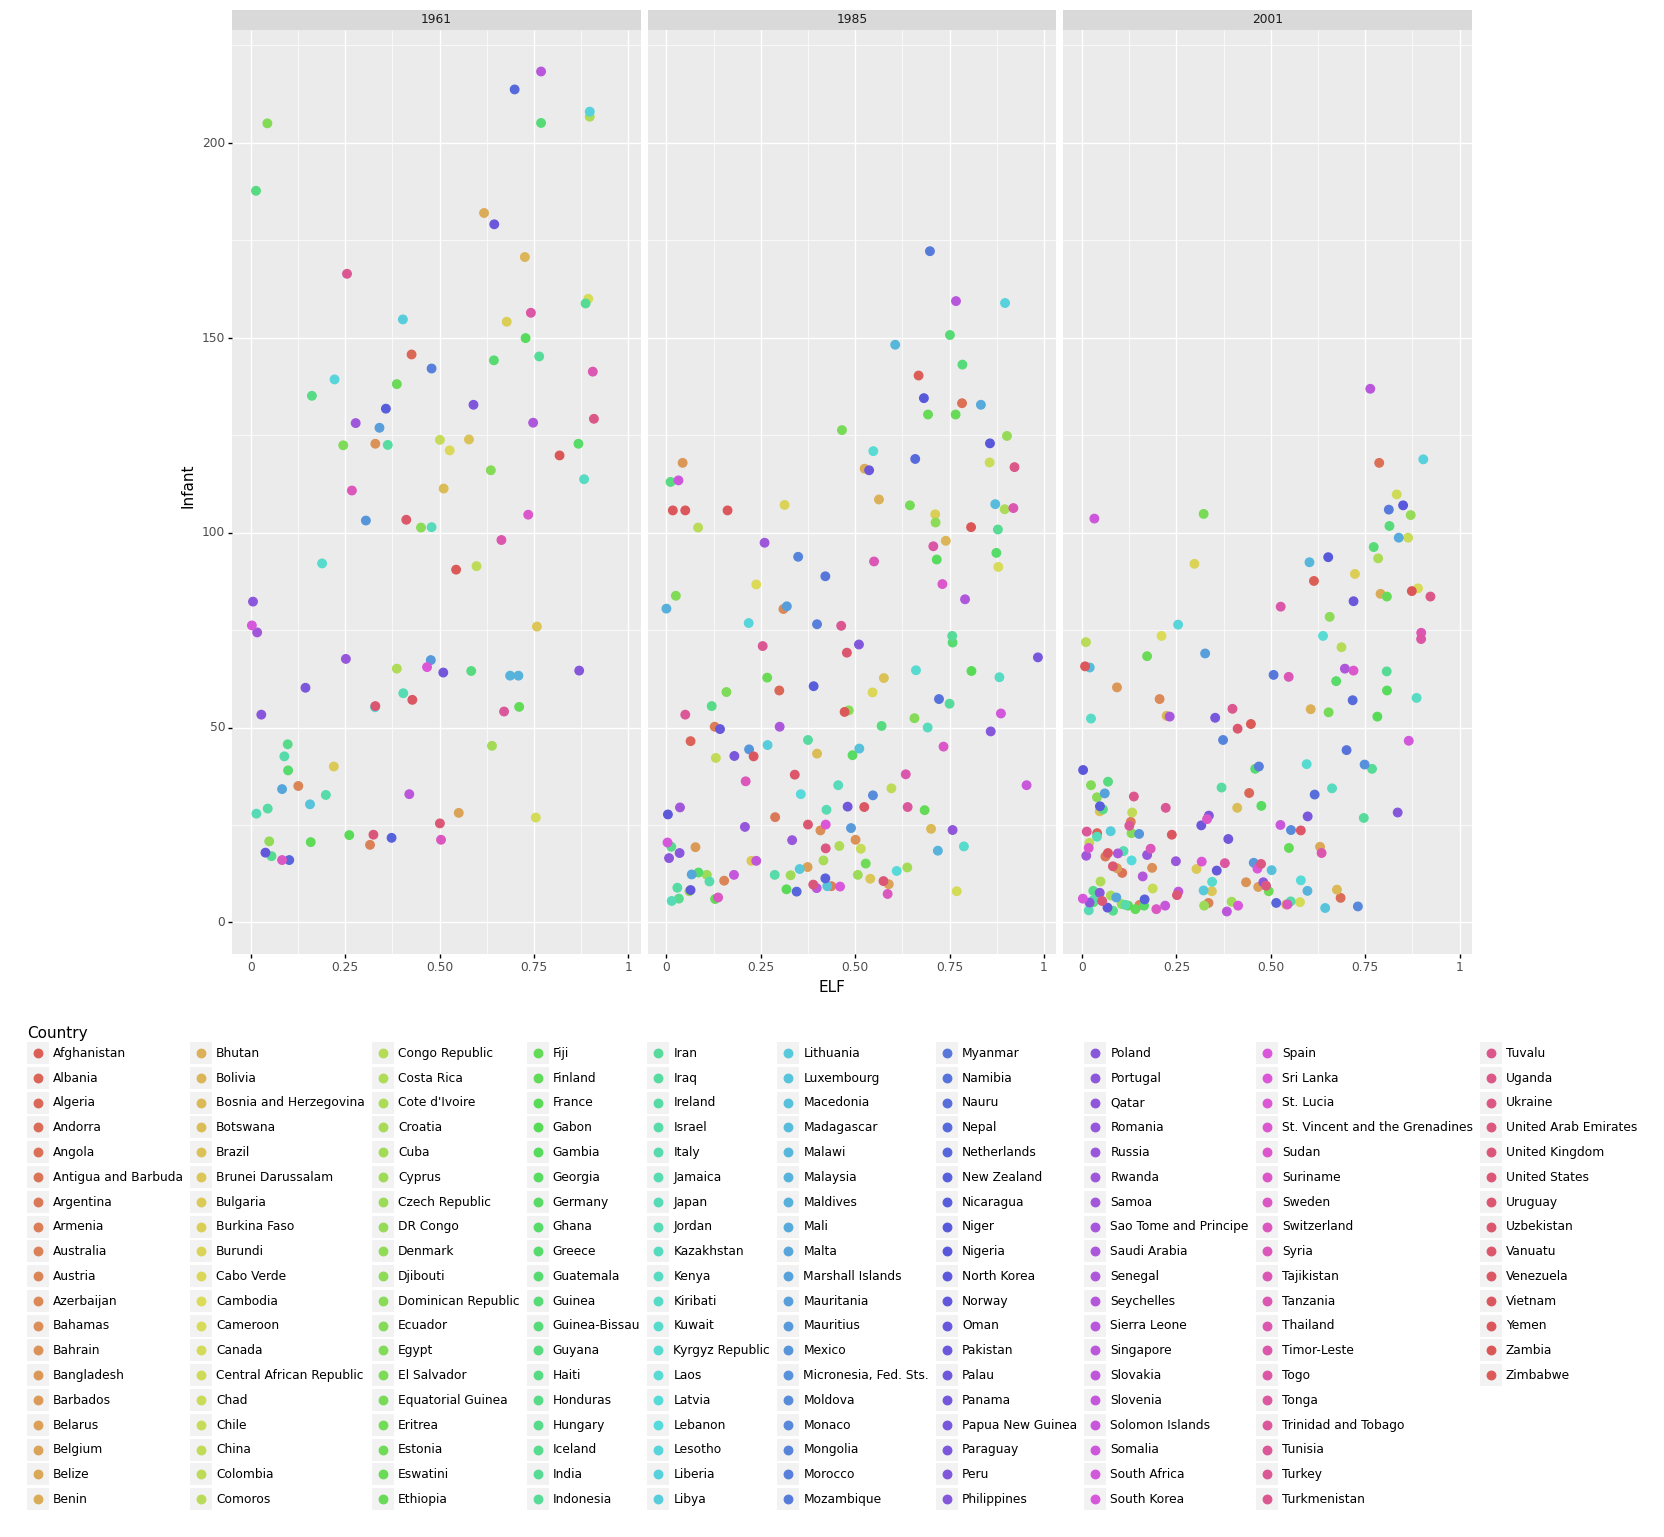

<ggplot: (322796885)>

In [31]:
(ggplot(temp, aes(x='ELF', y='Infant', color = "Country")) +
geom_point(size = 3) +
facet_wrap(['Year']) +
theme(legend_position = (0.5, -0.15), figure_size=(16, 12)))

<AxesSubplot:label='f72c7ed9-51ff-49e8-8186-56a2e8d32efa', xlabel='Year', ylabel='Infant'>

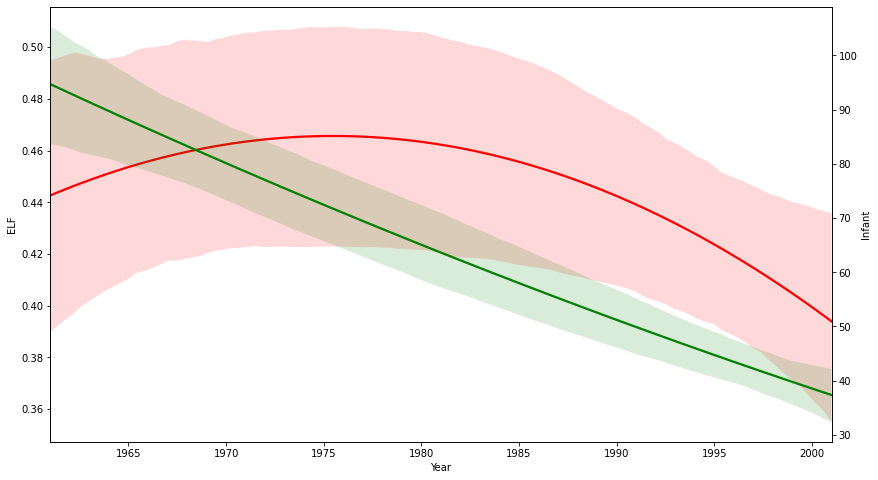

In [33]:
fig, ax = plt.subplots(figsize=(14, 8))
sns.regplot(x="Year", y= "ELF", data = temp, color = 'red', order = 2, ax = ax, scatter = False)
ax2 = ax.twinx()
sns.regplot(x="Year", y= "Infant", data = temp, color = 'green', order = 2, ax = ax2, scatter = False)

In [19]:
#Saved the absolute values of the correlation matrix
correlation = temp.corr().abs()

#Pivoted a level of the index labels
unstack_correlation = correlation.unstack()

#Sorted the correlations
compare = unstack_correlation.sort_values(kind="quicksort")

compare

Year    ELF       0.087516
ELF     Year      0.087516
        Infant    0.428920
Infant  ELF       0.428920
Year    Infant    0.467452
Infant  Year      0.467452
Year    Year      1.000000
ELF     ELF       1.000000
Infant  Infant    1.000000
dtype: float64

<AxesSubplot:>

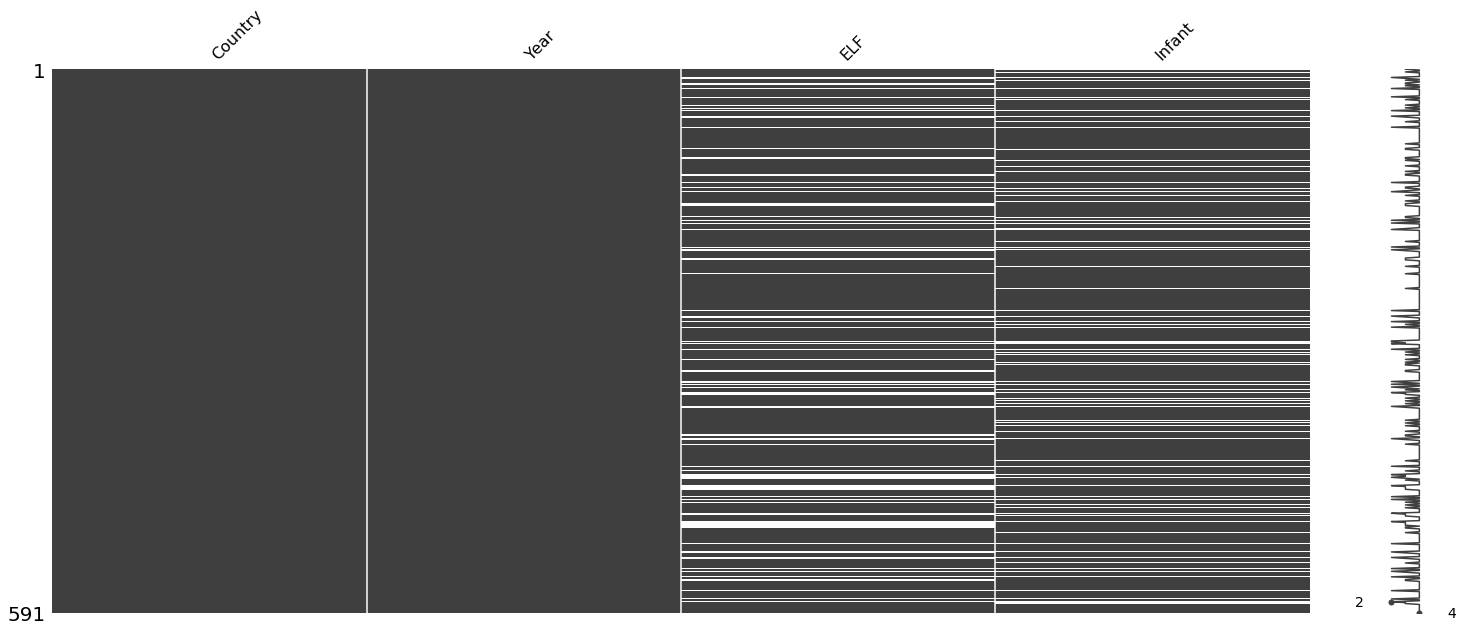

In [20]:
#Checked to see if that dataset was complete
miss.matrix(temp)

In [21]:
#Dropped all observations where the outcome is missing
temp = temp[~temp.ELF.isna()]
temp = temp[~temp.Infant.isna()]

In [22]:
temp_y = temp['ELF'] # OUTCOME: the log selling price
temp_X = temp[['Infant']] # PREDICTORS: simplified for our purposes

In [23]:
y = temp['ELF'] # OUTCOME: the log selling price
X = temp[['Infant']] # PREDICTORS: simplified for our purposes

# (0) Split the data 
train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=.25,random_state=1988)

# (1) Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=5, shuffle=True,random_state=111)

# (2) Next specify the preprocessing steps
preprocess = ColumnTransformer(transformers=[('num', pp.MinMaxScaler(), ['Infant'])])


# (3) Next Let's create our model pipe (note for the model we leave none as a placeholder)
pipe = Pipeline(steps=[('pre_process', preprocess),
                       ('model',None)])


# (4) Specify the models and their repsective tuning parameters. 
# Note the naming convention here to reference the model key
search_space = [
    # Linear Model
    {'model' : [LM()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[10,15,20,25,30]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DTree()],
     'model__max_depth':[1,2,3,5]},
    
    # The Bagging decision tree model 
    {'model': [Bag()]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
     'model__max_depth':[1,2,3],
     'model__n_estimators':[500,1000,1250]},
]


# (5) Put it all together in the grid search
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='neg_mean_squared_error',
                      n_jobs=4)

# (6) Fit the model to the training data
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=111, shuffle=True),
             estimator=Pipeline(steps=[('pre_process',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['Infant'])])),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [KNeighborsRegressor()],
                          'model__n_neighbors': [10, 15, 20, 25, 30]},
                         {'model': [DecisionTreeRegressor()],
                          'model__max_depth': [1, 2, 3, 5]},
                         {'model': [BaggingRegressor()]},
                         {'model': [RandomForestRegressor()],
                          'model__max_depth': [1, 2, 3],
                          'model__n_estimators': [

In [24]:
search.best_score_

-0.061607285717327785

In [25]:
search.best_params_

{'model': LinearRegression()}

In [26]:
# Predict() method will use the best model out of the scan
pred_y = search.predict(test_X)

In [27]:
m.mean_squared_error(test_y,pred_y)

0.06863161887728654

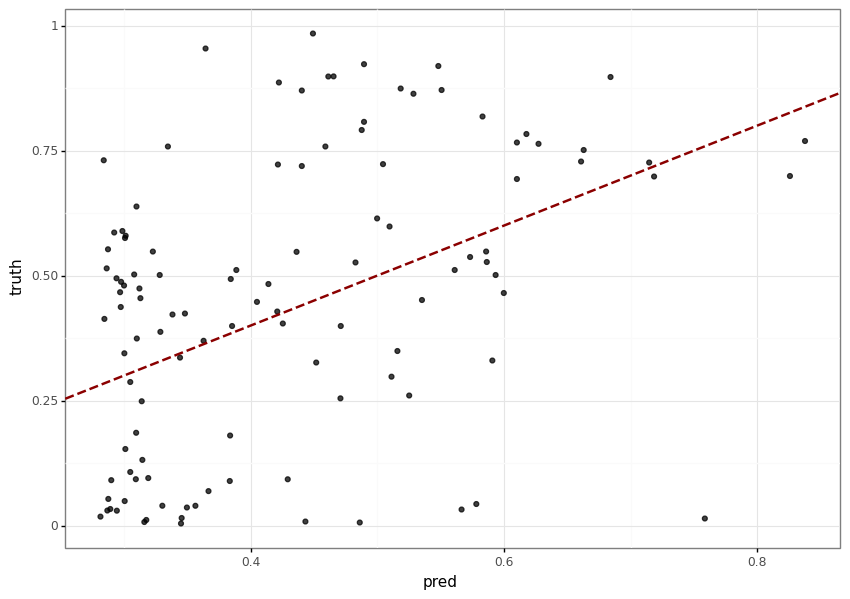

<ggplot: (315182150)>

In [28]:
(
    ggplot(pd.DataFrame(dict(pred=pred_y,truth=test_y)),
          aes(x='pred',y="truth")) +
    geom_point(alpha=.75) +
    geom_abline(linetype="dashed",color="darkred",size=1) +
    theme_bw() +
    theme(figure_size=(10,7))
)


### Learnings

* Dropping the Eurostat/internet useage dataset as a) it is survery based and b) doesn't have data for 2001 
* ELF research is really sparce (only have data for the years 1961, 1985, 2001)
* Data clean up is taking a lot more time than the visualization or machine learning component 

In [29]:
#Importing 2003 fractionalization dataset & dropping 5 rows
heir = pd.read_excel(r'Datasets/BL2013_F_v2.2.xls')
heir.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,NaN,NaN,"Educational Attainment for Female Population, ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Barro R. & J.W. Lee,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"v. 2.2, June 2018",NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,0,1,2,3.0,4,5,6,7,8,9,10,11,12,13,14,15,16
6,Country,Year,Age Group,NaN,No Schooling,Highest level attained,NaN,NaN,NaN,NaN,NaN,Avg. Years of Total Schooling,Avg. Years of Primary Schooling,Avg. Years of Secondary Schooling,Avg. Years of Tertiary\n Schooling,Population\n(1000s),Region
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,Primary,NaN,Secondary,NaN,Tertiary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,Total,Completed,Total,Completed,Total,Completed,NaN,NaN,NaN,NaN,NaN,NaN


#### Github Link: https://github.com/snadari/PPOL564_Final_Project_Fall_2020